# Obfuscating Insurance 

### The goal of our project is to take customer insurance information and use it to predict where customers may use insurance benefits. This will help insurance agents better understand their clients' needs and assess risks when offering insurance.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn.metrics import r2_score

In [2]:
url = 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/insurance_us.csv'
df = pd.read_csv(url)

In [3]:
display(df.info())  
display(df.describe()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

,Gender,Age,Salary,Family members,Insurance benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [4]:
# count for any duplicates
num_duplicates = df.duplicated().sum()
# print number of duplicate rows 
print(f"duplicate rows: {num_duplicates}")

duplicate rows: 153


### Reviewing the data, we do not see any Personally Identifiable Information(PII). We also do not find any data elements acting to uniquely identify each record, such as customer ID number. Given the limited dataset with only 5 columns and a limited number of accepted values for each column (gender = 0 or 1), we can estimate the probability of these being true duplicates. Ignoring the salary column because it could be considered continuous, for the remaining rows we have a probability of:

Probability = (1/2) x (1/47){Age max 65 - Age min 18} x (1/7) x (1/6) = 1/3948

### While ignoring the continuous variable of salary, we should only expect 1-2 duplicates, not 153. Therefore, we will drop them as actual duplicate values.

In [5]:
# drop duplicates
df = df.drop_duplicates()
# standardize column names
df.columns = df.columns.str.lower()

In [6]:
display(df.info())  

<class 'pandas.core.frame.DataFrame'>
Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   float64
 2   salary              4847 non-null   float64
 3   family members      4847 non-null   int64  
 4   insurance benefits  4847 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 227.2 KB


None

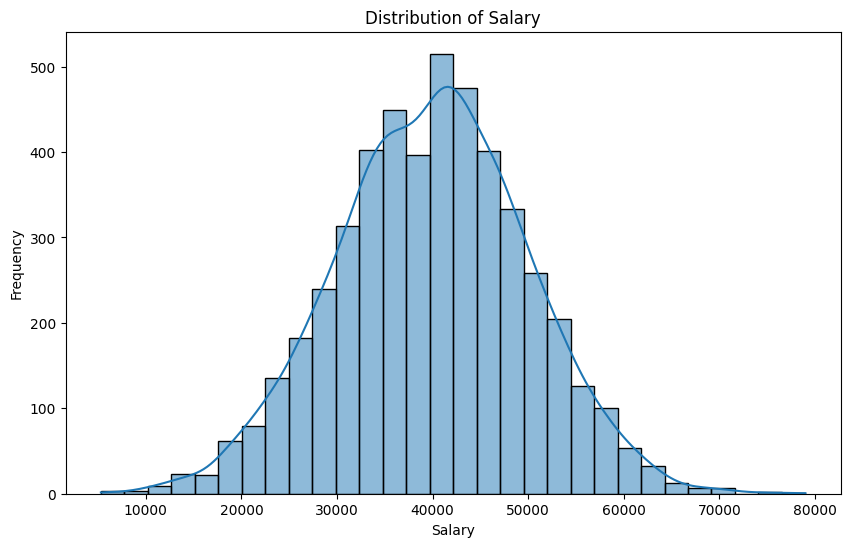

In [7]:
# graph salary
plt.figure(figsize=(10, 6))
sns.histplot(df['salary'], kde=True, bins=30)
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

### Other than dropping duplicates and standardizing column names, our data seem to fit acceptable norms for processing in our model.

# Find Similar Customers

In [8]:
# customer index
customer_index = 123
customer_vector = df.drop('insurance benefits', axis=1).loc[customer_index].values

# distances to other customer
distances = [distance.euclidean(customer_vector, df.drop('insurance benefits', axis=1).loc[i].values) for i in df.index]

similar_index = np.array(distances).argsort()[1]

print('similar customer:', similar_index)
print(df.loc[similar_index])

similar customer: 1876
gender                    1.0
age                      36.0
salary                49100.0
family members            0.0
insurance benefits        0.0
Name: 1876, dtype: float64


###  This will help the company's agents determine which other products may be interested in. 

## Predict Benefits for New Customer

In [9]:

# target
train_features = df.drop('insurance benefits', axis=1)
train_target = df['insurance benefits']

def nearest_neighbor_predict(train_features, train_target, new_features):
    distances = []
    for i in range(train_features.shape[0]):
        dist = distance.euclidean(new_features, train_features.iloc[i].values)
        distances.append(dist)
    best_index = np.argmin(distances)

    answer = train_target.iloc[best_index]
    return answer

# customer 
new_customer = np.array([0, 50, 42000, 1])

# Predict insurance benefits
prediction = nearest_neighbor_predict(train_features, train_target, new_customer)
print(f"Predicted insurance benefits for the new customer: {prediction}")

Predicted insurance benefits for the new customer: 2


### The function above uses the K-Nearest Neighbors (k-NN) algorithm to find the most similar customers based on the features provided. While this approach can be helpful in determining the risks associated with a new customer, it may be too literal. Just because one person utilizes benefits based on age and salary doesn't mean the next similar person will do the same. Our linear model below does a better job at averaging out these differences. Given more data, both in quantity and the number of features, we could further improve our ability to assess risk.

In [10]:
# linear regression
features = df.drop('insurance benefits', axis=1)
target = df['insurance benefits']

class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ (X.T @ y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
# model 
model = LinearRegression()
model.fit(features, target)

predictions = model.predict(features)

# new customer features
new_customer = np.array([0, 50, 42000, 1]).reshape(1, -1)

# predict
prediction = model.predict(new_customer)
print(f"Predicted benefits for the new customer: {prediction[0]:.2f}")
print(f"R2 Score: {r2_score(target, predictions)}")

Predicted benefits for the new customer: 0.84
R2 Score: 0.4302010044852068


### Generally, a trained model will do better than a dummy model at predicting where something might be true based on patterns it finds in the data. However, each modeling method has its limitations and is only as good as the data it was provided. Humans are also very good at finding patterns and suffer from similar pitfalls. Some people can look at clouds and recognize all different kinds of shapes and objects (overfitting), while others can look at the same clouds and fail to recognize any patterns (underfitting). You're actually doing this right now, our eyes all have blind spots, and our brains are constantly filling in the missing information with a prediction. To control for model errors, we preprocess the data to avoid giving our model erroneous information and then validate our results.

In [11]:
# adding random noise
np.random.seed(42)  
noise = np.random.normal(0, 1, features['salary'].shape)  
features['salary_noisy'] = features['salary'] + noise  
features = features.drop('salary', axis=1)  

### In the data provided, there is no single element that could be used to identify an individual. However, while annual income may not be unique to an individual it is quite specific. This information, along with other demographic details, could potentially lead to a breach of someone's personal information. To mitigate this risk we can add random noise to our model without affecting the results significantly.

In [12]:
# linear regression
features = df.drop('insurance benefits', axis=1)
target = df['insurance benefits']

class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ (X.T @ y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
# model 
model = LinearRegression()
model.fit(features, target)

predictions = model.predict(features)

# new customer features
new_customer = np.array([0, 50, 42000, 1]).reshape(1, -1)

# predict
prediction = model.predict(new_customer)
print(f"Predicted benefits for the new customer: {prediction[0]:.2f}")
print(f"R2 Score: {r2_score(target, predictions)}")

Predicted benefits for the new customer: 0.84
R2 Score: 0.4302010044852068


### There are some limits to our current model, using more data and different modeling techniques could improve our predictions. Still, this serves as an excellent example of how we can model, predict, and assess risks for both customers and insurance companies. By offering customers the right level of coverage and limiting risk when taking on new clients, we can enhance customer satisfaction and help save insurance company money.  

All project files are available at Github : https://github.com/Tom-Kinstle/sprint_11